In [3]:
import pandas as pd
import numpy as np
import os
import json
import glob
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
from scipy.spatial import Delaunay
from utils import *

In [4]:
# Load the JSON file
with open('./full_tracks.json', 'r') as f:
    df_tracks = json.load(f)

# Prepare rows for the DataFrame
rows = []
for entry in df_tracks:
    id_ = entry['id']
    team = entry['team']
    detections = entry['detections']
    for frame, values in detections.items():
        # Only process if values are in the expected format
        if len(values) >= 2:
            x = values[-2]
            y = values[-1]
            row = {
                'id': id_,
                'team': team,
                'frame': int(frame),
                'x': x,
                'y': y
            }
            rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)



In [5]:
df = df[df['team'] == 0]
df

,id,team,frame,x,y
0,1,0,699,0.687094,0.767182
1,1,0,700,0.685985,0.767605
2,1,0,701,0.685954,0.766577
3,1,0,702,0.686119,0.764632
4,1,0,703,0.684556,0.764824
...,...,...,...,...,...
2135755,204,0,134995,0.792128,0.362689
2135756,204,0,134996,0.789495,0.368106
2135757,204,0,134997,0.787519,0.370761
2135758,204,0,134998,0.788143,0.368061


In [6]:
def create_role_pdfs_of_tracks(df):

    players_role, initial_means = initialize_roles_with_kmeans_all(df, 10)

    players_role, role_pdfs = update_roles_all(players_role, initial_means, separation_bias=20.0)
    
    
    return players_role, role_pdfs

In [7]:
import pandas as pd

# Sort by frame to preserve temporal order
df_new = df.sort_values(by='frame')

# Find the first frame where each player ID appears
first_frames = df_new.groupby('id')['frame'].min().reset_index()

# Sort IDs by first appearance
sorted_ids = first_frames.sort_values(by='frame')['id'].tolist()

# Split IDs into chunks of 10
chunks = [sorted_ids[i:i + 10] for i in range(0, len(sorted_ids), 10)]


# Create blocks based on each ID chunk
blocks = []
for id_chunk in chunks:
    block_df = df[df['id'].isin(id_chunk)].copy()
    blocks.append(block_df.reset_index(drop=True))


In [8]:
blocks[0]

,id,team,frame,x,y
0,1,0,699,0.687094,0.767182
1,1,0,700,0.685985,0.767605
2,1,0,701,0.685954,0.766577
3,1,0,702,0.686119,0.764632
4,1,0,703,0.684556,0.764824
...,...,...,...,...,...
150975,10,0,17961,0.088780,0.468260
150976,10,0,17962,0.089688,0.470872
150977,10,0,17963,0.089688,0.470872
150978,10,0,17964,0.089366,0.471184


In [9]:
blocks[1][blocks[1]['id'] == 26].head(1)

,id,team,frame,x,y
93154,26,0,17966,0.089044,0.471496


In [10]:
remapped_blocks = []

for block in blocks:
    block = block.copy()

    # Get the 10 unique IDs in order of appearance in this block
    unique_ids = block['id'].drop_duplicates().tolist()
    
    # Map them to new unified IDs: 0–9
    id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
    
    # Apply the mapping
    block['id'] = block['id'].map(id_map)
    
    remapped_blocks.append(block)

# Merge all remapped blocks into one final dataframe
final_df = pd.concat(remapped_blocks, ignore_index=True)

# Check results
print("Final unique player IDs:", sorted(final_df['id'].unique()))


Final unique player IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
aligned_df = final_df.sort_values(by=['id', 'frame']).reset_index(drop=True)
aligned_df

,id,team,frame,x,y
0,0,0,699,0.687094,0.767182
1,0,0,700,0.685985,0.767605
2,0,0,701,0.685954,0.766577
3,0,0,702,0.686119,0.764632
4,0,0,703,0.684556,0.764824
...,...,...,...,...,...
1216632,9,0,134995,0.792128,0.362689
1216633,9,0,134996,0.789495,0.368106
1216634,9,0,134997,0.787519,0.370761
1216635,9,0,134998,0.788143,0.368061


In [12]:
aligned_df.iloc[15931:].head(10)

,id,team,frame,x,y
15931,0,0,17964,0.044380,0.293775
15932,0,0,17965,0.044380,0.293775
15933,0,0,17966,0.042731,0.290332
15934,0,0,17967,0.044380,0.293775
15935,0,0,17968,0.044380,0.293775
15936,0,0,17969,0.043115,0.289972
15937,0,0,17970,0.041455,0.286501
15938,0,0,17971,0.041840,0.286140
15939,0,0,17972,0.041840,0.286140
15940,0,0,17973,0.040556,0.282279


In [13]:
first_half_time_block = aligned_df[aligned_df['frame'] <= 67500]
first_half_time_block

,id,team,frame,x,y
0,0,0,699,0.687094,0.767182
1,0,0,700,0.685985,0.767605
2,0,0,701,0.685954,0.766577
3,0,0,702,0.686119,0.764632
4,0,0,703,0.684556,0.764824
...,...,...,...,...,...
1153908,9,0,67496,0.306737,0.451654
1153909,9,0,67497,0.307486,0.450762
1153910,9,0,67498,0.308235,0.449869
1153911,9,0,67499,0.309552,0.453034


In [14]:

# Assume df is your dataframe, and 'id' is the ID column name
unique_ids = first_half_time_block['id'].unique()
num_splits = 5

# Create list to hold the resulting dataframes
split_dfs = [pd.DataFrame() for _ in range(num_splits)]

# Split each ID's rows into 5 parts and distribute them
for uid in unique_ids:
    group = first_half_time_block[first_half_time_block['id'] == uid]
    split = np.array_split(group, num_splits)  # Automatically handles uneven splits
    for i in range(num_splits):
        split_dfs[i] = pd.concat([split_dfs[i], split[i]], ignore_index=True)

# Now split_dfs[0] through split_1_half_dfs[4] contain chunks of each ID

split_dfs[4]

,id,team,frame,x,y
0,0,0,54148,0.753609,0.379610
1,0,0,54149,0.754945,0.377094
2,0,0,54150,0.753313,0.382181
3,0,0,54151,0.753934,0.382224
4,0,0,54152,0.754348,0.382253
...,...,...,...,...,...
117777,9,0,67496,0.306737,0.451654
117778,9,0,67497,0.307486,0.450762
117779,9,0,67498,0.308235,0.449869
117780,9,0,67499,0.309552,0.453034


In [15]:
for i, split_df in enumerate(split_dfs):
   
    split_df['xworld'] = split_df['x'] * 105
    split_df['yworld'] = split_df['y'] * 68
    split_df[['xworld_norm', 'yworld_norm']] = split_df.groupby('frame')[['xworld', 'yworld']].transform(
        lambda x: x - x.mean())
    print(split_df.head())

   id  team  frame         x         y     xworld     yworld  xworld_norm  \
0   0     0    699  0.687094  0.767182  72.144920  52.168376     7.891519   
1   0     0    700  0.685985  0.767605  72.028476  52.197158     7.758711   
2   0     0    701  0.685954  0.766577  72.025164  52.127212     6.475262   
3   0     0    702  0.686119  0.764632  72.042480  51.995008     7.775145   
4   0     0    703  0.684556  0.764824  71.878389  52.008044     6.354272   

   yworld_norm  
0    30.974025  
1    31.133317  
2    30.633289  
3    30.848114  
4    30.547482  
   id  team  frame         x         y     xworld     yworld  xworld_norm  \
0   0     0  13879  0.352581  0.268202  37.020970  18.237714    -8.740193   
1   0     0  13880  0.352900  0.267769  37.054495  18.208305    -8.730891   
2   0     0  13881  0.352196  0.262114  36.980538  17.823754    -8.798710   
3   0     0  13882  0.352162  0.258820  36.977050  17.599779    -8.796953   
4   0     0  13883  0.351085  0.250142  36.863961 

In [16]:
every_4th_split_dfs = [df.iloc[::4].reset_index(drop=True) for df in split_dfs]
for i, df in enumerate(every_4th_split_dfs):
    print(f"Split {i} shape: {df.shape}")
   

Split 0 shape: (29448, 9)
Split 1 shape: (29448, 9)
Split 2 shape: (29447, 9)
Split 3 shape: (29446, 9)
Split 4 shape: (29446, 9)


In [17]:
every_4th_split_dfs[0].head(10)

,id,team,frame,x,y,xworld,yworld,xworld_norm,yworld_norm
0,0,0,699,0.687094,0.767182,72.144920,52.168376,7.891519,30.974025
1,0,0,703,0.684556,0.764824,71.878389,52.008044,6.354272,30.547482
2,0,0,707,0.684683,0.761840,71.891698,51.805113,9.006449,28.756911
3,0,0,711,0.684247,0.755446,71.845952,51.370334,9.013393,28.159153
4,0,0,715,0.682143,0.753338,71.625067,51.226978,10.106239,26.610720
5,0,0,719,0.681148,0.750761,71.520590,51.051777,7.365852,30.352380
6,0,0,723,0.681754,0.742669,71.584181,50.501485,8.874265,27.057381
7,0,0,727,0.678930,0.740226,71.287625,50.335388,8.530401,28.043619
8,0,0,731,0.677729,0.738583,71.161571,50.223635,7.778390,28.396828
9,0,0,735,0.675474,0.738544,70.924822,50.220981,7.879352,27.957395


In [18]:
# Load the fitted label encoder (recommended way)
label_encoder = joblib.load('./label_encoder.pkl')
adjacency_matrices = []
players_roles_list = []
role_pdfs_list = []

for i, df in enumerate(every_4th_split_dfs):
    players_role, role_pdfs = create_role_pdfs_of_tracks(df)
    players_roles_list.append(players_role)
    role_pdfs_list.append(role_pdfs)
    role_means = np.array([pdf.mean for pdf in role_pdfs.values()])

    # Check if there are enough points for Delaunay triangulation
    if len(role_means) >= 3:
        # Perform Delaunay triangulation
        tri = Delaunay(role_means)

        # Initialize adjacency matrix
        adj_matrix = np.zeros((len(role_means), len(role_means)))

        # Populate adjacency matrix based on Delaunay simplices
        for simplex in tri.simplices:
            for i in range(len(simplex)):
                for j in range(i + 1, len(simplex)):
                    distance = np.linalg.norm(role_means[simplex[i]] - role_means[simplex[j]])
                    adj_matrix[simplex[i], simplex[j]] = distance
                    adj_matrix[simplex[j], simplex[i]] = distance
        adjacency_matrices.append(adj_matrix)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14


In [25]:
import joblib
for i, matr in enumerate(adjacency_matrices):
    # Step 1: Extract features from the new adjacency matrix
    new_features = extract_features(matr)

    # Step 2: Reshape to 2D array for prediction
    new_features = new_features.reshape(1, -1)

    # Step 3: Predict using the KNN model
    knn_model = joblib.load('./KNN_best_model.pkl')
    predicted_label_encoded = knn_model.predict(new_features)[0]

    # Step 4: Load the fitted label encoder
    label_encoder = joblib.load('./label_encoder.pkl')

    # Step 5: Decode the predicted label
    predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]

    print("Predicted formation (decoded):", predicted_label)


Predicted formation (decoded): 4231
Predicted formation (decoded): 352
Predicted formation (decoded): 4231
Predicted formation (decoded): 4231
Predicted formation (decoded): 442


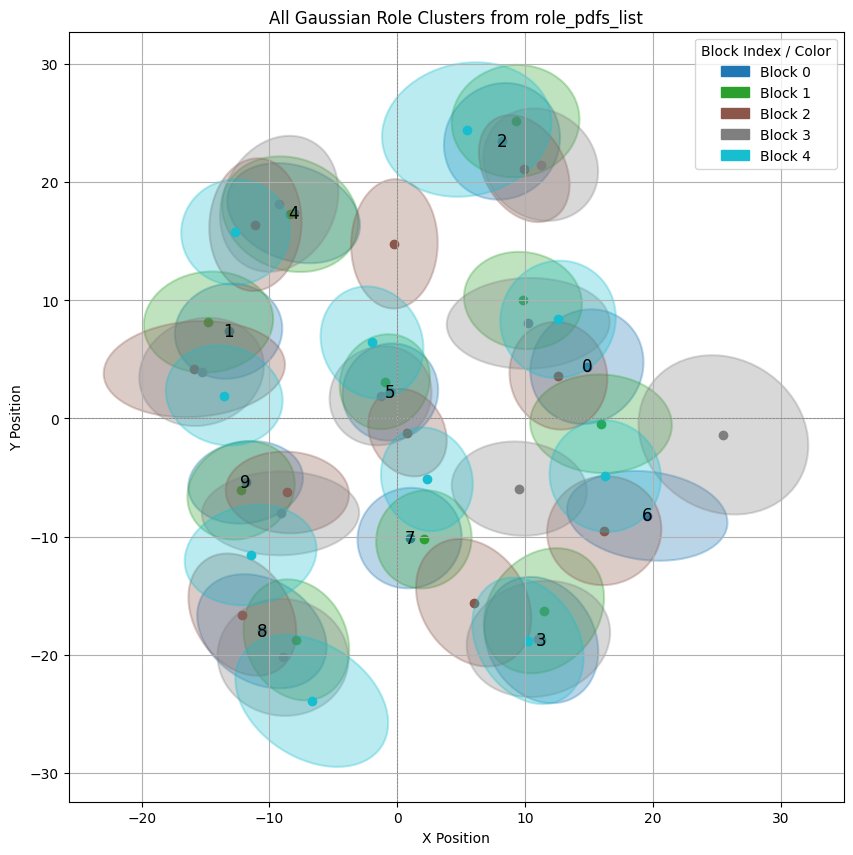

In [20]:
from matplotlib.patches import Ellipse, Patch
import matplotlib.pyplot as plt
def plot_gaussian_ellipse(mean, cov, ax, label=None, alpha=0.5, color=None):
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * np.sqrt(eigvals)
    ellipse = Ellipse(mean, width, height, angle=angle, alpha=alpha, lw=1.5, edgecolor=color, facecolor=color)
    ax.add_patch(ellipse)
    ax.scatter(mean[0], mean[1], color=color)
    if label is not None:
        ax.text(mean[0], mean[1], str(label), color='black', fontsize=12, ha='center', va='center')
fig, ax = plt.subplots(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(role_pdfs_list)))
legend_handles = []
for idx, role_pdfs in enumerate(role_pdfs_list):
    color = colors[idx % len(colors)]
    legend_handles.append(Patch(color=color, label=f'Block {idx}'))
    for role, pdf in role_pdfs.items():
        mean = pdf.mean
        cov = pdf.cov
        plot_gaussian_ellipse(mean, cov, ax, label=f"{role}" if idx == 0 else None, alpha=0.3, color=color)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("All Gaussian Role Clusters from role_pdfs_list")
plt.grid(True)
ax.legend(handles=legend_handles, title="Block Index / Color")
plt.show()




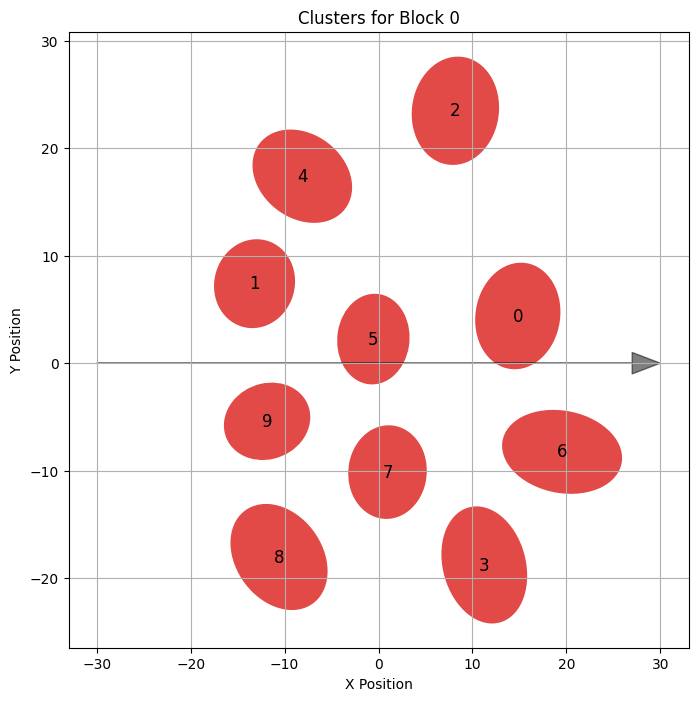

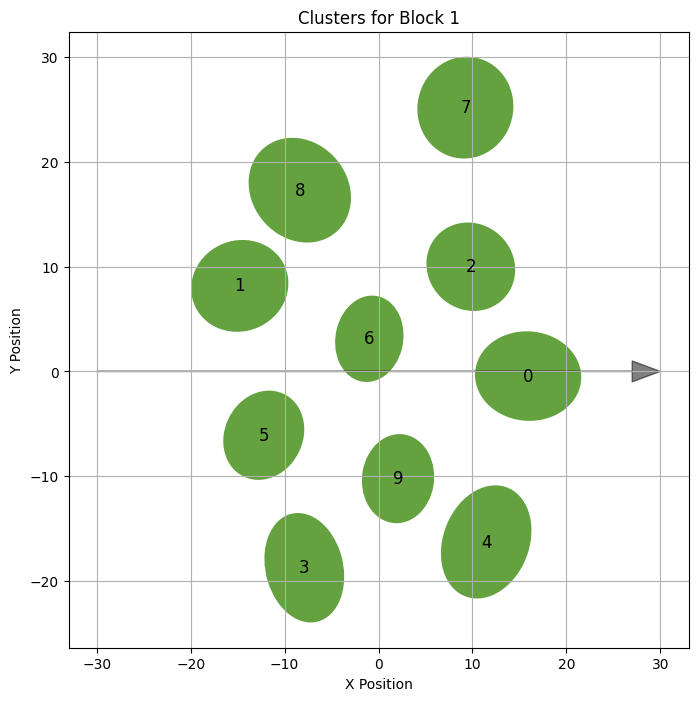

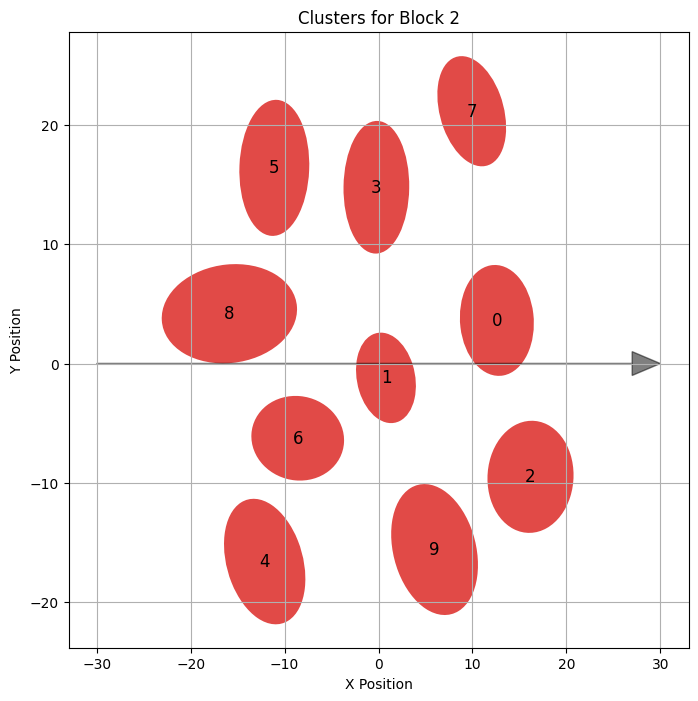

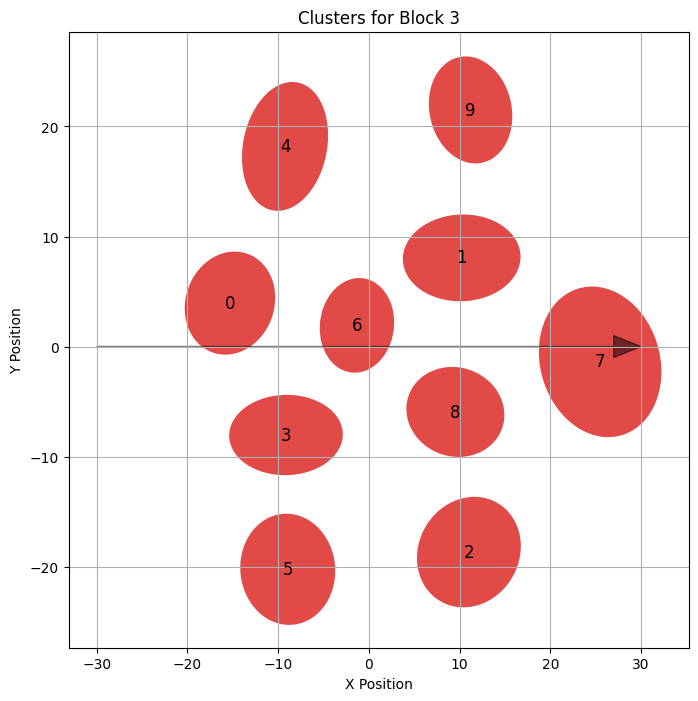

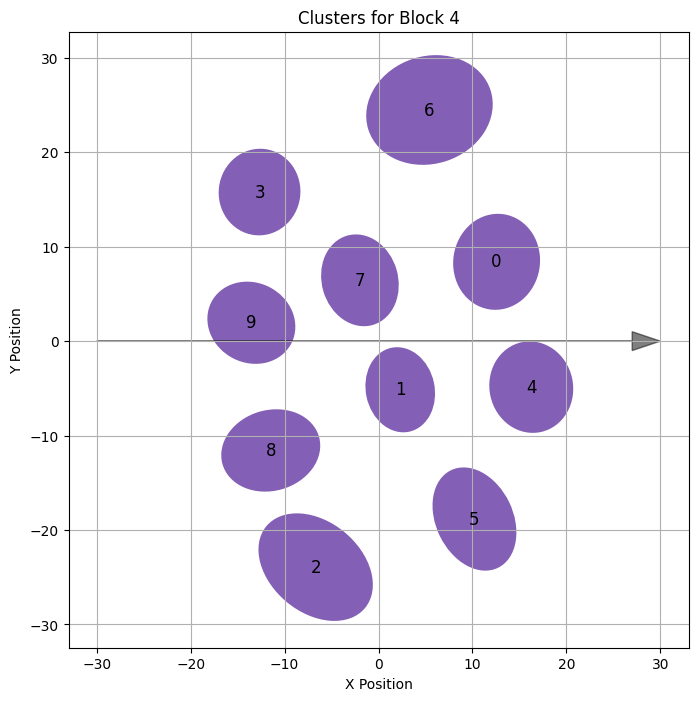

In [38]:
custom_colors = [
    (225/255, 74/255, 71/255),   # First: red-ish
    (99/255, 162/255, 63/255),   # Second: green-ish
    (225/255, 74/255, 71/255),   # Third: red-ish
    (225/255, 74/255, 71/255),   # Fourth: red-ish
    (131/255, 95/255, 181/255),  # Fifth: purple-ish
    colors[4]                    # Fifth: keep as before or set as needed
]

for idx, role_pdfs in enumerate(role_pdfs_list):
    fig, ax = plt.subplots(figsize=(8, 8))
    color = custom_colors[idx]
    for role, pdf in role_pdfs.items():
        mean = pdf.mean
        cov = pdf.cov
        plot_gaussian_ellipse(mean, cov, ax, label=f"{role}", alpha=1, color=color)
    # Draw left-to-right arrow
    ax.arrow(-30, 0, 60, 0, head_width=2, head_length=3, fc='black', ec='black', alpha=0.5, length_includes_head=True)
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_title(f"Clusters for Block {idx}")
    plt.grid(True)
    plt.show()
